In [1]:
import numpy as np
import scipy
from lib.aux import PCAVector
import os
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets

# Example 3: Gradient projection

## Definitions

### Auxiliary functions

In [2]:
def doAnalysis(tagList):
    # summarized spectral analysis of all experiments given by tagList

    # list of time parameters, eigenvalues of psi deformations, eigenvalues of transport map deformations
    TList=[]
    eigvalListY=[]
    eigvalList=[]
    
    for tag in tagList:
        if os.path.isfile("data/"+tag+"_tan.npz"):
            
            # load problem specifications    
            data=np.load("data/"+tag+".npz")
            X=data["X"]
            mu=data["dens"]
            YList=data["YList"]
            T=float(data["t"])

            # load precomputed optimal transport maps
            dataTan=np.load("data/"+tag+"_tan.npz")
            vecList=dataTan["vec"]

            nSamp,nPts,dim=YList.shape
            
            eigval,eigvec=PCAVector(vecList/T, mu)
            order=np.argsort(-eigval)
            eigvalList.append(eigval[order])

            eigvalY,eigvecY=PCAVector((YList-X)/T, mu)
            orderY=np.argsort(-eigvalY)
            eigvalListY.append(eigvalY[orderY])
            
            TList.append(T)
    
    TList=np.array(TList)
    eigvalList=np.array(eigvalList)
    eigvalListY=np.array(eigvalListY)
    
    return TList,eigvalList,eigvalListY

def getTangentNorm(Z,mu):
    return np.linalg.norm(Z,axis=1)@mu

def plotEigvals(ax,TList,eigvalList,lines=False,**kwargs):
    nT,keep=eigvalList.shape
    if lines:
        for i in range(keep):
            ax.plot(TList,eigvalList[:,i],**kwargs)
    else:
        for i in range(keep):
            ax.scatter(TList,eigvalList[:,i],**kwargs)

def addLines(ax,X,Y,**kwargs):
    """Add line collection from points in X to points in Y to axis object. X,Y are assumed to have shape [nPoints,dim]."""
    linecoords=np.stack([X,Y],axis=1)
    lineCollection=matplotlib.collections.LineCollection(linecoords,**kwargs)
    ax.add_collection(lineCollection)


### Vector field and diffeomorphisms

In [4]:
# 1d basic bump function
def f(x):
    return np.exp(-1/(1-x**2))

# clip inadmissible values, take x**2 as effective argument (simplifies chain rule below)
def g(x):
    xclp=np.clip(x,0,1-1E-10)
    return (x<1)*np.exp(-1/(1-xclp))

# g prime, g double prime
def gp(x):
    xclp=np.clip(x,0,1-1E-10)
    return (x<1)*-np.exp(-1/(1-xclp))/(1-xclp)**2

def gpp(x):
    xclp=np.clip(x,0,1-1E-10)
    return (x<1)*np.exp(-1/(1-xclp))*(1/(1-xclp)**4-2/(1-xclp)**3)

# modified bump function with additional exp scaling, and its derivatives
def g2(x,scale=0.5):
    return g(x)*np.exp(-x/scale**2)

def g2p(x,scale=0.5):
    return gp(x)*np.exp(-x/scale**2)-g(x)*np.exp(-x/scale**2)/scale**2

def g2pp(x,scale=0.5):
    return gpp(x)*np.exp(-x/scale**2)-2*gp(x)*np.exp(-x/scale**2)/scale**2+g(x)*np.exp(-x/scale**2)/scale**4

# full 2d bump, gradient and hessian
def getG(x,A,z,scale):
    rSqr=0.5*np.einsum(x-z,[0,2],A,[2,3],x-z,[0,3],[0])
    return g2(rSqr,scale)

def getDG(x,A,z,scale):
    rSqr=0.5*np.einsum(x-z,[0,2],A,[2,3],x-z,[0,3],[0])
    dim=x.shape[1]
    gpval=g2p(rSqr,scale).reshape((-1,1))
    return gpval*np.einsum(A,[2,1],x-z,[0,1],[0,2])

def getHG(x,A,z,scale):
    rSqr=0.5*np.einsum(x-z,[0,2],A,[2,3],x-z,[0,3],[0])
    dim=x.shape[1]
    gpval=gp(rSqr,scale).reshape((-1,1,1))
    gppval=gpp(rSqr,scale).reshape((-1,1,1))
    return gppval*np.einsum(A,[3,1],x-z,[0,1],x-z,[0,2],A,[4,2],[0,3,4])+gpval*A.reshape((1,dim,dim))

# psi can be generated as gradient of several bumps + identity
def getPsi(x,zList,aList,precList,scale):
    result=x.copy()
    for z,a,prec in zip(zList,aList,precList):
        result+=a*getDG(x,prec,z,scale)
    return result

# differential of psi
def getDPsi(x,zList,aList,precList,scale):
    n,dim=x.shape
    result=np.zeros((n,dim,dim))
    result[...]=np.identity(dim,dim).reshape((1,dim,dim))
    for z,a,prec in zip(zList,aList,precList):
        result+=a*getHG(x,prec,z,scale)
    return result

### A simple parametric deformation and template

In [8]:
def getR(phi):
    return np.array([[np.cos(phi),-np.sin(phi)],[np.sin(phi),np.cos(phi)]])

In [9]:
def getPsiSimple(X,s,t):
    """Apply deformed psi (parametrized by s,t in [0,1] x [0,1]) to grid X."""
    zList=[np.array([0.,0.])]
    aList=[0.15*(t-0.5)]
    R=getR(np.pi/4)
    precList=[2/1**2*R@np.array([[1.8,0.],[0.,1.]])@R.T]
    scale=0.5
    Y=getPsi(X,zList,aList,precList,scale)
    R=getR(0.1*np.pi*2*(s-0.5))
    
    Y=np.einsum(R,[1,2],Y,[0,2],[0,1])
    return Y

In [13]:
# create template
dim=2
def getData(scale,nPts1dBase=51):
    """Return point cloud X and weights dens, given a scale parameter (which should be integer, usually 1,2,4,...)"""
    nPts1d=nPts1dBase*scale
    x1=np.linspace(-1,1,num=nPts1d)
    x2=np.linspace(-1,1,num=nPts1d)
    X = np.stack(np.meshgrid(x1, x2),axis=2).reshape((-1,dim))
    
    covdens=2*np.array([[0.01,0.],[0.,0.05]])
    # precision matrix of the Gaussian bump part
    precdens=np.linalg.inv(covdens)
    # mask: keep only points within unit ball
    maskdens=(np.linalg.norm(X,axis=1)<1)
    dens=(0.1+np.exp(-0.5*np.einsum(X,[0,1],X,[0,2],precdens,[1,2],[0])))*maskdens
    dens=dens/np.sum(dens)

    dens=dens[maskdens]
    XFull=X.copy()
    X=X[maskdens]


    return XFull,X,dens

## Plotting and designing

### Dynamic plot of deformation

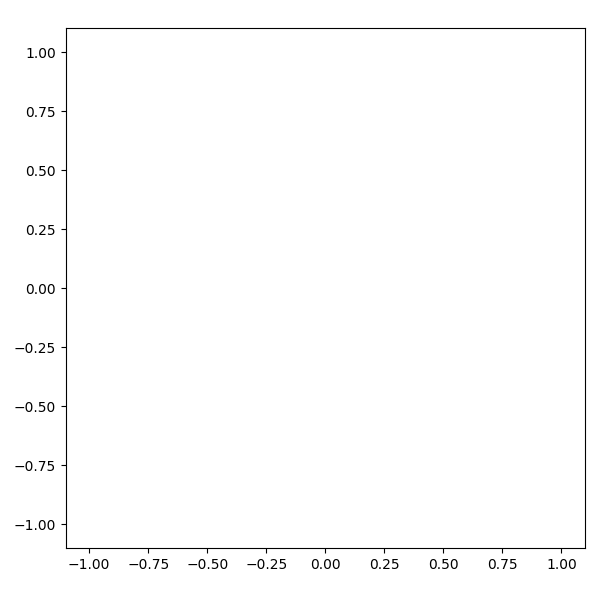

interactive(children=(FloatSlider(value=0.5, description='s', max=1.0), FloatSlider(value=0.5, description='t'…

In [11]:
%matplotlib widget
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(aspect=1.)


plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.tight_layout()
plt.show()

scale=1
XFull,X,dens=getData(scale)

def update(s,t):
    Y=getPsiSimple(X,s,t)
    [l.remove() for l in ax.patches]
    [l.remove() for l in ax.collections]
    
    ax.scatter(Y[:,0],Y[:,1],s=10,zorder=2,c="C0")
    #ax.scatter(X[:,0],X[:,1],s=10,zorder=2,c="C0")
    #addLines(ax,X,X+DPhi,zorder=-1,lw=1,color="k")
    #for z,a,prec in zip(zList,aList,precList):
    #    ax.add_patch(getEllipse(z,np.linalg.inv(prec),fill=False,color="r",linewidth=2))
    fig.canvas.draw_idle()
    #print("x")

update(0.5,0.5)

widgets.interact(update, s=(0.,1.), t = (0.,1.));


In [12]:
plt.close()

### Grid plot of some exemplary deformations

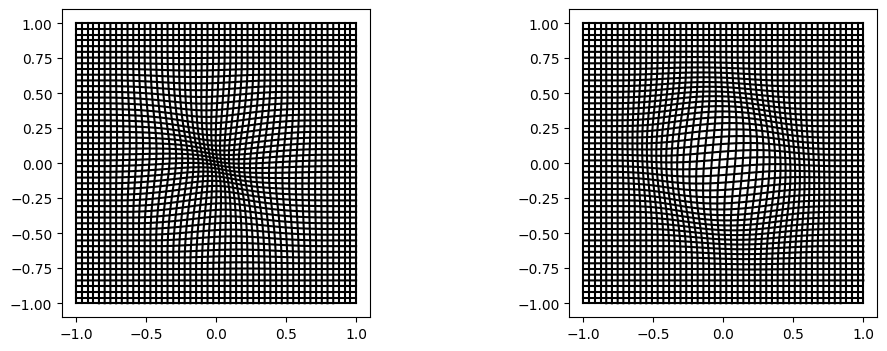

In [27]:
nPts1dPlt=50
XPlt,_,_=getData(1,nPts1dPlt)

YPlt1=getPsiSimple(XPlt,0.5,1).reshape((nPts1dPlt,nPts1dPlt,dim))
YPlt2=getPsiSimple(XPlt,0.5,0).reshape((nPts1dPlt,nPts1dPlt,dim))

%matplotlib inline
fig=plt.figure(figsize=(12,4))

for i,YPlt in enumerate([YPlt1,YPlt2]):
    fig.add_subplot(1,2,i+1,aspect=1.)
    for i in range(nPts1dPlt):
        plt.plot(YPlt[i,:,0],YPlt[i,:,1],c="k")
        plt.plot(YPlt[:,i,0],YPlt[:,i,1],c="k")
plt.show()

### Density estimates of deformed template

In [28]:
nPts1dDens=100
_,XDens,densDens=getData(1,nPts1dDens)

In [29]:
from sklearn.neighbors import KernelDensity

In [30]:
XDens1=getPsiSimple(XDens,0.5,1)
XDens2=getPsiSimple(XDens,0.5,0)
kde0 = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(XDens,sample_weight=densDens)
kde1 = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(XDens1,sample_weight=densDens)
kde2 = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(XDens2,sample_weight=densDens)
density0 = np.exp(kde0.score_samples(XPlt.reshape((-1,dim)))).reshape((nPts1dPlt,nPts1dPlt))
density1 = np.exp(kde1.score_samples(XPlt.reshape((-1,dim)))).reshape((nPts1dPlt,nPts1dPlt))
density2 = np.exp(kde2.score_samples(XPlt.reshape((-1,dim)))).reshape((nPts1dPlt,nPts1dPlt))
del kde1,kde2,kde0
del XDens1,XDens2

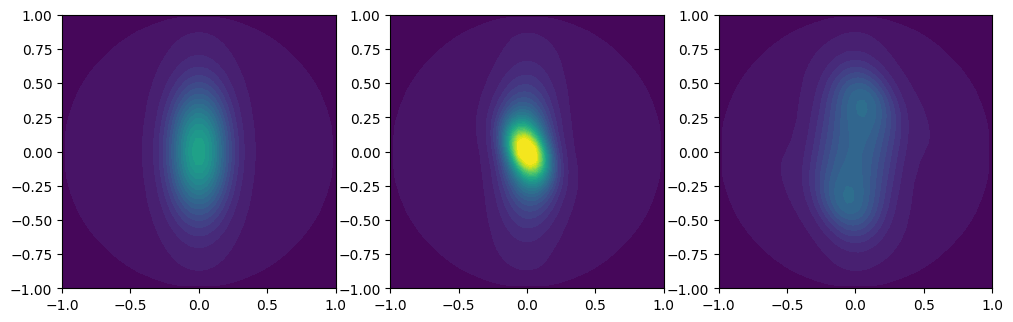

In [31]:
fig=plt.figure(figsize=(12,4))
for i,dens in enumerate([density0,density1,density2]):
    ax=fig.add_subplot(1,3,i+1,aspect=1.)
    ax.contourf(np.clip(dens,0,3),extent=[-1,1,-1,1],levels=np.linspace(0,3,num=30))
plt.show()

# Tangent space analysis

## Generate sample measures

In [33]:
# template and resolution
# scale should be one of [1,2,4,8] (will take pretty long for scale>1)
scale=1
_,X,dens=getData(scale)
print(X.shape)

(1941, 2)


In [34]:
# time scaling

# geometric scaling factor: 10 steps per order of magnitude
q=10**(-0.1)
TList=q**np.arange(8)
idList=list(range(len(TList)))
print(TList)

[1.         0.79432823 0.63095734 0.50118723 0.39810717 0.31622777
 0.25118864 0.19952623]


In [35]:
# tag list for storage and retrieval of experiment data
tagList=[f"example3/scale_{scale:}/{i:02}" for i in range(len(TList))]
print(tagList)

['example3/scale_1/00', 'example3/scale_1/01', 'example3/scale_1/02', 'example3/scale_1/03', 'example3/scale_1/04', 'example3/scale_1/05', 'example3/scale_1/06', 'example3/scale_1/07']


In [36]:
# parameters for solver script
# will be added to config file for documentation purposes
if scale==1:
    paramsSolver={"param_hierarchyDepth":6,"param_eps":5e-4,"param_afterSteps":5}
elif scale==2:
    paramsSolver={"param_hierarchyDepth":7,"param_eps":1.2e-4,"param_afterSteps":5}
elif scale==4:
    paramsSolver={"param_hierarchyDepth":8,"param_eps":3e-5,"param_afterSteps":5}
elif scale==8:
    paramsSolver={"param_hierarchyDepth":9,"param_eps":8e-6,"param_afterSteps":5}
else:
    raise ValueError("no solver params specified for given scale.")

In [38]:
theta0=np.array([0.5,0.5])
Y0=getPsiSimple(X,*theta0)
rel1=np.linspace(-0.5,0.5,num=5)

for tag,T in zip(tagList,TList):
    # parameters that should be used as tangent vectors
    thetaList=T*np.stack(np.meshgrid(rel1,rel1,indexing="ij"),axis=2).reshape((-1,2))+theta0
    # deformed template positions
    YList=np.array([getPsiSimple(X,*theta) for theta in thetaList])
    # deformed densities (just copies)
    densList=np.repeat(dens.reshape((1,-1)),len(YList),axis=0)
    data={"t":T,"thetaList":thetaList,"YList":YList,"X":Y0,"theta0":theta0,"dens":dens,"densList":densList}
    # next line commented to avoid accidental overwriting
    np.savez("data/"+tag+".npz",**data,**paramsSolver)

## Solve transport problems

In [107]:
# now need to run:
# path/to/python3 ./solve-experiments.py tag
# this requires the MultiScaleOT lib, see https://bernhard-schmitzer.github.io/MultiScaleOT/
# for all tag in tag list, then can continue with evaluation of results
# for simplicity, the repository contains the config and results files for scale=1

## Spectral analysis

In [51]:
scale=1
tagList=[f"example3/scale_{scale:}/{i:02}" for i in range(len(TList))]
specTList,eigvalList,eigvalListY=doAnalysis(tagList)

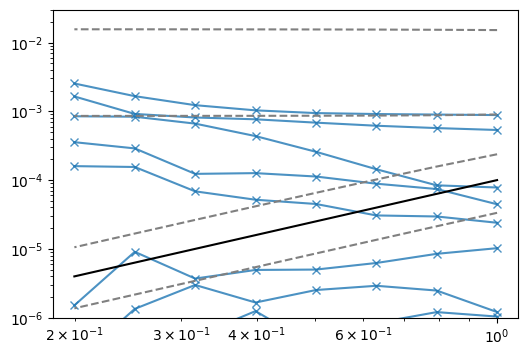

In [52]:
%matplotlib inline
ylim=[1E-6,3E-2]

fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(1,1,1)
plotEigvals(ax,specTList,eigvalList,lines=True,marker="x",color="C0",alpha=0.8)
plotEigvals(ax,specTList,eigvalListY,lines=True,marker="",color="#808080",ls="dashed")
plt.plot(specTList,0.0001*specTList**2,c="k")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(ylim)


plt.show()